In [6]:
import pandas as pd
import numpy as np

from scipy.stats import norm
from scipy.optimize import brentq

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
day_0 = pd.read_csv('./p3_data/round3/prices_round_3_day_0.csv', sep=';')
day_1 = pd.read_csv('./p3_data/round3/prices_round_3_day_1.csv', sep=';')
day_2 = pd.read_csv('./p3_data/round3/prices_round_3_day_2.csv', sep=';')

day_1['timestamp'] += 1_000_000
day_2['timestamp'] += 2_000_000

df = pd.concat([day_0, day_1, day_2])
df_volcanic_rock = df[df['product'] == 'VOLCANIC_ROCK'][['timestamp', 'mid_price', 'day']]
df_volcanic_rock_vouchers = df[df['product'].str.startswith('VOLCANIC_ROCK_VOUCHER')]

df_volcanic_rock_vouchers = df_volcanic_rock_vouchers.merge(df_volcanic_rock, on='timestamp', suffixes=('', '_volcanic_rock'))
df_volcanic_rock_vouchers['time_to_expiry'] = 8 / 365 - df_volcanic_rock_vouchers['timestamp'] / 1_000_000 / 365

df_volcanic_rock_vouchers = df_volcanic_rock_vouchers[['timestamp', 'product', 'mid_price', 'mid_price_volcanic_rock', 'time_to_expiry']]
df_volcanic_rock_vouchers['strike'] = df_volcanic_rock_vouchers['product'].str.extract(r'(\d+)$').astype(int)
df_volcanic_rock_vouchers

,timestamp,product,mid_price,mid_price_volcanic_rock,time_to_expiry,strike
0,0,VOLCANIC_ROCK_VOUCHER_10500,99.5,10503.0,0.021918,10500
1,0,VOLCANIC_ROCK_VOUCHER_10000,505.5,10503.0,0.021918,10000
2,0,VOLCANIC_ROCK_VOUCHER_9750,754.5,10503.0,0.021918,9750
3,0,VOLCANIC_ROCK_VOUCHER_9500,1003.5,10503.0,0.021918,9500
4,0,VOLCANIC_ROCK_VOUCHER_10250,273.5,10503.0,0.021918,10250
...,...,...,...,...,...,...
149995,2999900,VOLCANIC_ROCK_VOUCHER_10500,3.5,10166.5,0.013699,10500
149996,2999900,VOLCANIC_ROCK_VOUCHER_10250,36.5,10166.5,0.013699,10250
149997,2999900,VOLCANIC_ROCK_VOUCHER_10000,180.5,10166.5,0.013699,10000
149998,2999900,VOLCANIC_ROCK_VOUCHER_9750,417.5,10166.5,0.013699,9750


In [8]:
def realised_volatility(df):
    df = df.copy()
    df = df.sort_values('timestamp')

    df['log_returns'] = np.log(df['mid_price'] / df['mid_price'].shift(1))
    std_return = df['log_returns'].std()
    return std_return * np.sqrt(10000) * np.sqrt(365)

print("Realised Volatility: ", realised_volatility(df_volcanic_rock))

Realised Volatility:  0.47819602665563404


#### Black Scholes Equations
https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model

Assumes risk-free interest rate is 0%.

In [9]:
def black_scholes_call_price(spot, strike, time_to_expiry, volatility):
    d1 = (np.log(spot / strike) + (0.5 * volatility ** 2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
    d2 = d1 - volatility * np.sqrt(time_to_expiry)
    return spot * norm.cdf(d1) - strike * norm.cdf(d2)
    
def delta(spot, strike, time_to_expiry, volatility):
    d1 = (np.log(spot / strike) + (0.5 * volatility ** 2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
    return norm.cdf(d1)
    
def gamma(spot, strike, time_to_expiry, volatility):
    d1 = (np.log(spot / strike) + (0.5 * volatility ** 2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
    return norm.pdf(d1) / (spot * volatility * np.sqrt(time_to_expiry))

def vega(spot, strike, time_to_expiry, volatility):
    d1 = (np.log(spot / strike) + (0.5 * volatility ** 2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
    return spot * norm.pdf(d1) * np.sqrt(time_to_expiry)
    
def theta(spot, strike, time_to_expiry, volatility):
    d1 = (np.log(spot / strike) + (0.5 * volatility ** 2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
    return -(spot * norm.pdf(d1) * volatility) / (2 * np.sqrt(time_to_expiry))
    
def rho(spot, strike, time_to_expiry, volatility):
    d2 = (np.log(spot / strike) - (0.5 * volatility ** 2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
    return strike * time_to_expiry * norm.cdf(d2)

def implied_volatility(call_price, spot, strike, time_to_expiry):
    # Define the equation where the root is the implied volatility
    def equation(volatility):
        estimated_price = black_scholes_call_price(spot, strike, time_to_expiry, volatility)
        return estimated_price - call_price

    # Using Brent's method to try to find the root of the equation
    try:
        implied_vol = brentq(equation, 1e-10, 3.0, xtol=1e-10)
        return implied_vol
    except ValueError:
        return np.nan

In [10]:
df_volcanic_rock_vouchers['implied_vol'] = df_volcanic_rock_vouchers.apply(
    lambda row: implied_volatility(
        row['mid_price'],
        row['mid_price_volcanic_rock'],
        row['strike'],
        row['time_to_expiry']
    ),
    axis=1
)

In [11]:
df_volcanic_rock_vouchers['delta'] = df_volcanic_rock_vouchers.apply(
    lambda row: delta(
        row['mid_price_volcanic_rock'],
        row['strike'],
        row['time_to_expiry'],
        row['implied_vol']
    ), axis=1
)

In [12]:
df_volcanic_rock_vouchers['gamma'] = df_volcanic_rock_vouchers.apply(
    lambda row: gamma(
        row['mid_price_volcanic_rock'],
        row['strike'],
        row['time_to_expiry'],
        row['implied_vol']
    ), axis=1
)

In [13]:
df_volcanic_rock_vouchers['vega'] = df_volcanic_rock_vouchers.apply(
    lambda row: vega(
        row['mid_price_volcanic_rock'],
        row['strike'],
        row['time_to_expiry'],
        row['implied_vol']
    ), axis=1
)

In [14]:
df_volcanic_rock_vouchers['theta'] = df_volcanic_rock_vouchers.apply(
    lambda row: theta(
        row['mid_price_volcanic_rock'],
        row['strike'],
        row['time_to_expiry'],
        row['implied_vol']
    ), axis=1
)

In [15]:
df_volcanic_rock_vouchers['rho'] = df_volcanic_rock_vouchers.apply(
    lambda row: rho(
        row['mid_price_volcanic_rock'],
        row['strike'],
        row['time_to_expiry'],
        row['implied_vol']
    ), axis=1
)

In [16]:
strike_prices = [10_500, 10_250, 10_000, 9_750, 9_500]

for strike in strike_prices:
    implied_vol = df_volcanic_rock_vouchers[df_volcanic_rock_vouchers['strike'] == strike]['implied_vol']
    print('------------------------------------------------')
    print('Strike: ', strike)
    print('Implied Volatility Mean: ', implied_vol.mean())
    print('Implied Volatility SD: ', implied_vol.std())
    print('# NA Values: ', implied_vol.isna().sum())

print('------------------------------------------------')

print('All Implied Volatility Mean: ', df_volcanic_rock_vouchers['implied_vol'].mean())


------------------------------------------------
Strike:  10500
Implied Volatility Mean:  0.15665158192652745
Implied Volatility SD:  0.006770216546365593
# NA Values:  0
------------------------------------------------
Strike:  10250
Implied Volatility Mean:  0.15355861552965788
Implied Volatility SD:  0.0034112703215153192
# NA Values:  0
------------------------------------------------
Strike:  10000
Implied Volatility Mean:  0.16402082308888433
Implied Volatility SD:  0.01048205750065354
# NA Values:  0
------------------------------------------------
Strike:  9750
Implied Volatility Mean:  0.17528725015256627
Implied Volatility SD:  0.052409962444076266
# NA Values:  52
------------------------------------------------
Strike:  9500
Implied Volatility Mean:  0.1416706975756656
Implied Volatility SD:  0.11996875691138341
# NA Values:  401
------------------------------------------------
All Implied Volatility Mean:  0.15827628880193698


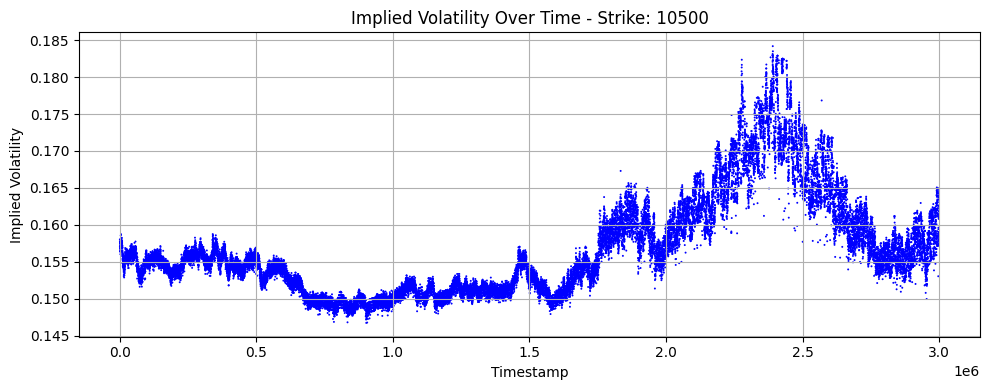

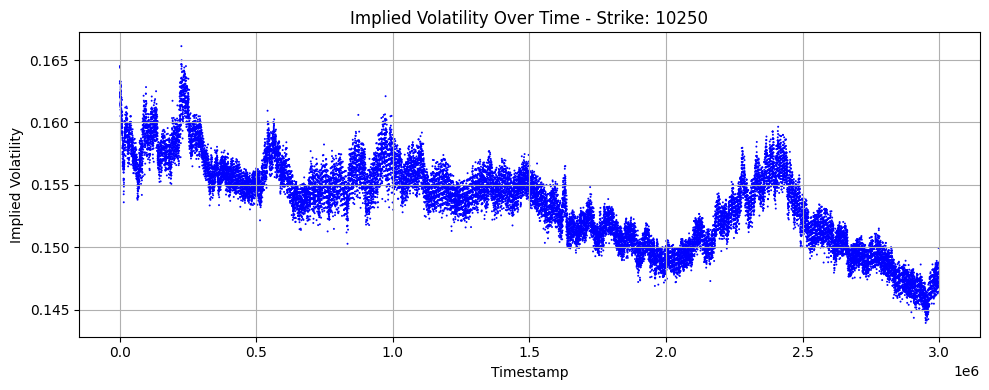

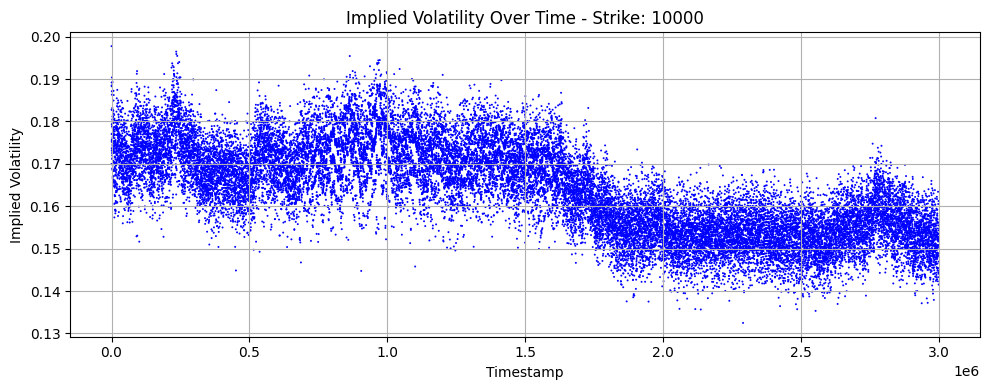

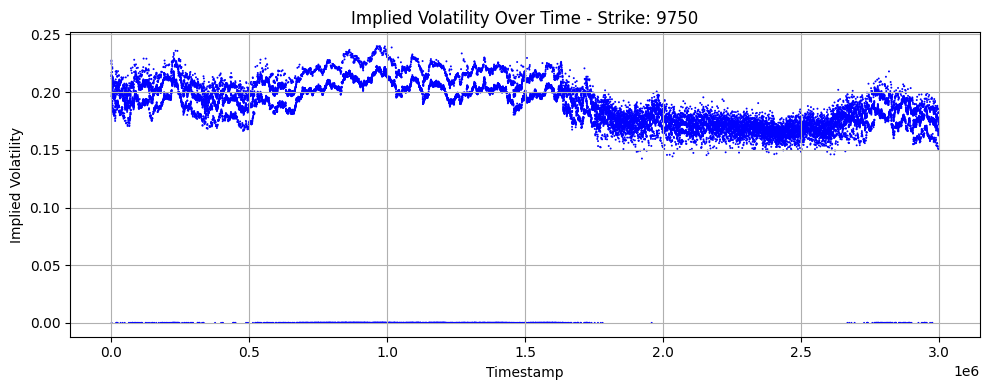

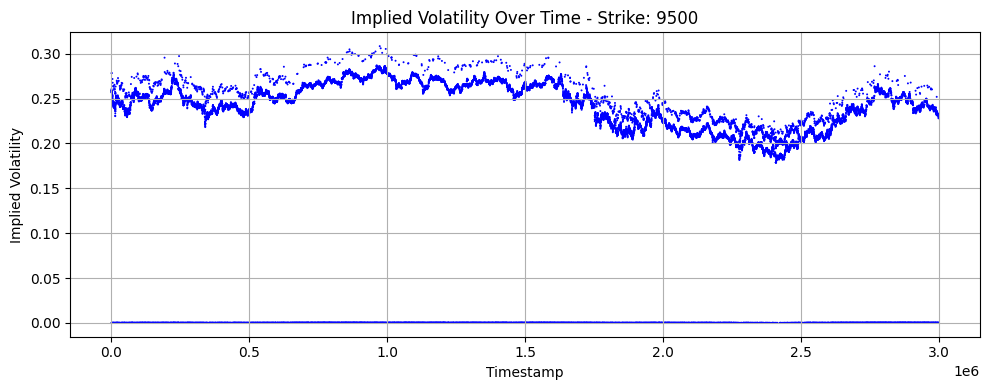

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

for strike in strike_prices:
    strike_df = df_volcanic_rock_vouchers[df_volcanic_rock_vouchers['strike'] == strike]
    plt.figure(figsize=(10, 4))
    sns.scatterplot(data=strike_df, x='timestamp', y='implied_vol', s=2, color='blue', edgecolor='none')  
    plt.title(f'Implied Volatility Over Time - Strike: {strike}')
    plt.xlabel('Timestamp')
    plt.ylabel('Implied Volatility')
    plt.grid(True)
    plt.tight_layout()
    plt.show()